# Preprocessing

In [1]:
# Imports & stuff

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from cycler import cycler
from scipy.signal import savgol_filter

# Constants
time = 3600
discount = 0.95
pres_sarsop = []
pres_ub = []
# all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag", "Hallway1", "Hallway2", "MiniHallway", "TigerGrid"] # All envs
all_envs = ["ABC", "Tiger","grid", "RockSample5", "RockSample7",
             "K-out-of-N2", "K-out-of-N3", "aloha30","Tag",  "SparseTigerGrid","SparseHallway1", "SparseHallway2", "pentagon", "fourth"  ]
# Missing: "sunysb", "fourth" (Never run) & 

# all_envs = ["ABC", "Tiger", "RockSample5", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag",  "SparseHallway1", "SparseHallway2", "SparseTigerGrid"] # Messing around...
Env_to_latex_name = {
    "ABC" : "\\custom",
    "Tiger":"\\tiger",
    "RockSample5": "\\rocksample (5,3)",
    "RockSample10": "\\rocksample (10,4)",
    "RockSample11": "\\rocksample (11,11)",
    "RockSample7": "\\rocksample (7,8)",
    "K-out-of-N2":"\\koutofn (2)",
    "K-out-of-N3":"\\koutofn (3)",
    "FrozenLake4":"\\lake (4)",
    "FrozenLake10":"\\lake (10)",
    "Tag":"\\tagenv",
    "Hallway1":"\\hallway1",
    "Hallway2":"\\hallway2",
    "TigerGrid":"\\tigergrid",
    "Sparse_Hallway1":"\\hallwayone",
    "Sparse_Hallway2":"\\hallwaytwo",
    "SparseHallway1":"\\hallwayone",
    "SparseHallway2":"\\hallwaytwo",
    "SparseTigerGrid":"\\tigergrid",
    "MiniHallway":"\\minihallway",
    "aloha10":"\\aloha (10)", 
    "aloha30":"\\aloha (30)", 
    "cit":"\\cit", 
    "fourth":"\\fourth", 
    "mit":"\\mit", 
    "pentagon":"\\pentagon", 
    "sunysb":"\\sunysb", 
    "grid":"\\gridenv"
}

solver_to_heuristic = {
    "SARSOP" : "FIB",
    "TIB-SARSOP" : "TIB",
    "ETIB-SARSOP" : "ETIB"
}



# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4"] #Testing envs
# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4", "FrozenLake10", "K-out-of-N3"] #Testing envs
pre_sarsop = "./Data/SarsopTest/Sarsoptest_"
pre_ub = "./Data/UpperBounds/UpperBoundTest_"
post_sarsop = f"_t{time}_d{str(discount)[2:]}_OnlyBs.json"
# post_sarsop = f"_t{time}_d{str(discount)[2:]}.json"
post_ub =f"_d{str(discount)[2:]}.json"
for env in all_envs:
    pres_ub.append(pre_ub + env + "_")

# solvers = ["SARSOP", "TIB-SARSOP", "ETIB-SARSOP"]
solvers = ["SARSOP", "TIB-SARSOP", "ETIB-SARSOP"]
# solvers = ["SARSOP", "TIB-SARSOP"]

def get_data_plot(env:str):
    ts, ubs, lbs = [], [], []
    solvernames, envname = [], ""
    for s in solvers:
        filename = pre_sarsop+env+"_"+s+post_sarsop
        with open(filename) as file:
            data = json.load(file)
            ts.append(data["times"])
            ubs.append(data["ubs"])
            lbs.append(data["lbs"])
            solvernames.append(data["solver"])
            envname = data["env_full"]

    return ts, ubs, lbs, solvernames, envname


def get_data_discounts(env, discounts):
    times, init_times = [], []
    solvernames = []
    for (s_idx, s) in enumerate(solvers):
        solvernames.append(s)
        times.append([])
        init_times.append([])
        for d in discounts:
            filename = f'./Data/DiscountTest/Sarsoptest_{env}_{s}_t{time}_d{str(round(d, 4))[2:]}.json'
            with open(filename) as file:
                data = json.load(file)
                times[s_idx].append(data["runtime"])
                init_times[s_idx].append(data["times"][0])

    return times, init_times, solvernames


def size_to_string(size:int):
    if size < 1000:
        return str(size)
    elif size < 10_000:
        return f'{(size/1_000):.1f}k'
    return f'{(size/1_000):.0f}k'

def value_to_string(nmbr:float):
    if abs(nmbr) < 10:
        return f'{nmbr:.2f}'
    elif abs(nmbr) < 100:
        return f'{nmbr:.1f}'
    else:
        return f'{nmbr:.0f}'
    
def time_to_string(nmbr:float, can_timeout=True):
    if nmbr < 1:
        return "<1s"
    elif nmbr < 100:
        return f'{nmbr:.0f}s'
    elif nmbr < 1200 or not can_timeout:
        return f'{nmbr:.0f}s'
    else:
        return "TO"



# Tables

## SARSOP - Large & Small

In [2]:
# SARSOP Convergence test - Large

def get_valuebounds_sarsop(data:dict, tmax, addAnd=False):
    times, ubs, lbs = data["times"], data["ubs"], data["lbs"]
    for (i, t) in enumerate(times):
        if t > tmax:
            if i == 0:
                return "N/A"
            # diff = abs(( ubs[i] - lbs[i]) / ubs[i])
            diff = f'{abs(( ubs[i-1] - lbs[i-1]) / lbs[i-1]):.2f}'
            diff =  f'{lbs[i-1]:.2f}, {ubs[i-1]:.2f}'
            break
            # diff =  f'{lbs[i-1]:.2f}, {ubs[i-1]:.2f} '
    # diff = abs(( data["final_ub"] - data["final_lw"]) / data["final_ub"])
    # diff = abs(( data["final_ub"] - data["final_lw"]) / data["final_lb"])
    if addAnd:
        diff = "& "+diff
    return diff


# labels = ["\\SARSOP", "\\TIBSARSOP", "\\ETIBSARSOP"]
# labels = ["\\FIB", "", "\\TIB","", "\\ETIB",""]
# labels = ["900s", "1800s", "3600s", "900s", "1800s", "3600s","900s", "1800s", "3600s"]
labels = ["\\FIB", "\\TIB", "\\ETIB","\\FIB", "\\TIB", "\\ETIB","\\FIB", "\\TIB", "\\ETIB"]
# labels = ["15 min", "30 min", "60 min","15 min", "30 min", "60 min","15 min", "30 min", "60 min",]
names = []
Data = []
for _l in labels:
    Data.append([])


times = [600, 1200, 3600]

for env in all_envs:
    pres_sarsop.append(pre_sarsop + env + "_" )
# envs_sarsop = ["RockSample10","K-out-of-N3", "Tag","SparseHallway1", "SparseHallway2","SparseTigerGrid",
#                "cit", "fourth", "mit", "pentagon", "grid"]
envs_sarsop = ["grid","RockSample7","K-out-of-N3", "Tag","SparseTigerGrid", 
               "SparseHallway1", "SparseHallway2",  "pentagon", "fourth",  ]

for env in envs_sarsop:
    thispre = pre_sarsop + env + "_"
    filename_Sarsop = thispre + "SARSOP" + post_sarsop
    # print(pre)
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        names.append(Env_to_latex_name[this_data["env"]])
        Data[0].append(get_valuebounds_sarsop(this_data, times[0], addAnd=True))
        Data[3].append(get_valuebounds_sarsop(this_data, times[1], addAnd=True))
        Data[6].append(get_valuebounds_sarsop(this_data, times[2], addAnd=True))

    filename_TIBSarsop = thispre + "TIB-SARSOP" + post_sarsop
    with open(filename_TIBSarsop) as file:
        this_data = json.load(file)
        Data[1].append(get_valuebounds_sarsop(this_data, times[0]))
        Data[4].append(get_valuebounds_sarsop(this_data, times[1]))
        Data[7].append(get_valuebounds_sarsop(this_data, times[2]))

    filename_ETIBSarsop = thispre + "ETIB-SARSOP" + post_sarsop
    with open(filename_ETIBSarsop) as file:
        this_data = json.load(file)
        Data[2].append(get_valuebounds_sarsop(this_data, times[0]))
        Data[5].append(get_valuebounds_sarsop(this_data, times[1]))
        Data[8].append(get_valuebounds_sarsop(this_data, times[2]))

# dataframe = pd.DataFrame([Sarsop_lb, Sarsop_ub, TIBSarsop_lb, TIBSarsop_ub,ETIBSarsop_lb, ETIBSarsop_ub,], index=labels, columns=names).transpose()

dataframe = pd.DataFrame(Data, index=labels, columns=names).transpose()


print(dataframe)

print(dataframe.to_latex(column_format="l||rrr|rrr|rrr"))

                              \FIB           \BIB          \EBIB  \
\gridenv              & 6.42, 7.50     6.41, 7.42     6.41, 6.89   
\rocksample (7,8)   & 20.45, 25.45   20.16, 25.68   19.65, 25.71   
\koutofn (3)        & -2.63, -2.07   -2.63, -2.33   -2.63, -2.32   
\tagenv            & -10.86, -6.05  -10.86, -6.44  -10.87, -6.45   
\tigergrid            & 2.28, 2.53     2.26, 2.47     2.24, 2.47   
\hallwayone           & 0.99, 1.21     0.99, 1.15     0.97, 1.15   
\hallwaytwo           & 0.32, 0.91     0.34, 0.86            N/A   
\pentagon             & 0.32, 0.38     0.33, 0.38            N/A   
\fourth               & 0.05, 0.09     0.04, 0.09            N/A   

                              \FIB           \BIB          \EBIB  \
\gridenv              & 6.42, 7.29     6.42, 7.24     6.42, 6.84   
\rocksample (7,8)   & 20.92, 25.25   20.75, 25.27   21.09, 25.38   
\koutofn (3)        & -2.63, -2.10   -2.63, -2.35   -2.63, -2.34   
\tagenv            & -10.85, -6.13  -10.84, -6.

In [3]:
# SARSOP Convergence test - Small

def get_time_per_iter(data:dict):
    if len(data["times"]) == 1:
        return "N/A"
    avg_time = (data["runtime"] - data["times"][0]) / (len(data["times"])-1)
    return f'{avg_time:.2e}s'

def get_perc_heuristic_time(data:dict):
    return (data["times"][0] / data["runtime"])

# labels = ["\\FIB", "", "\\TIB","", "\\ETIB","", "\\OTIB",""]
labels = ["\\FIB", "\\TIB","\\ETIB"]
# labels = ["T", "N_E","T", "N_E","T", "N_E", ]
names = []

Data = []
for _l in labels:
    Data.append([])

envs_sarsop = ["ABC","Tiger", "RockSample5", "K-out-of-N2", "aloha30"]
# envs_sarsop = ["ABC","Tiger", "RockSample5", "FrozenLake4"]

for env in all_envs:
    pres_sarsop.append(pre_sarsop + env + "_" )



for env in envs_sarsop:
    thispre = pre_sarsop + env + "_"
    filename_Sarsop = thispre + "SARSOP" + post_sarsop
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        names.append(Env_to_latex_name[this_data["env"]])
        Data[0].append(f'& {time_to_string(this_data["runtime"], False)}')
        # Data[1].append(len(this_data["times"])-1)
        # Data[1].append(get_perc_heuristic_time(this_data))


    filename_TIBSarsop = thispre + "TIB-SARSOP" + post_sarsop
    with open(filename_TIBSarsop) as file:
        this_data = json.load(file)
        Data[1].append(f'& {time_to_string(this_data["runtime"], False)}')
        # Data[3].append(len(this_data["times"])-1)
        # Data[3].append(get_perc_heuristic_time(this_data))

    filename_ETIBSarsop = thispre + "ETIB-SARSOP" + post_sarsop
    with open(filename_ETIBSarsop) as file:
        this_data = json.load(file)
        Data[2].append(f'& {time_to_string(this_data["runtime"], False)}')
        # Data[5].append(len(this_data["times"])-1)
        # Data[5].append(get_perc_heuristic_time(this_data))

    # filename_ETIBSarsop = thispre + "OTIB-SARSOP" + post_sarsop
    # with open(filename_ETIBSarsop) as file:
    #     this_data = json.load(file)
    #     Data[6].append(f'{this_data["runtime"]:.2f}s')
    #     Data[7].append(len(this_data["times"])-1)



print(Data)
# dataframe = pd.DataFrame([Sarsop_lb, Sarsop_ub, TIBSarsop_lb, TIBSarsop_ub,ETIBSarsop_lb, ETIBSarsop_ub,], index=labels, columns=names).transpose()

dataframe = pd.DataFrame( Data, index=labels, columns=names).transpose()


print(dataframe)

print(dataframe.to_latex(column_format="lcrcrcr"))

[['& <1s', '& <1s', '& <1s', '& 615s', '& 47s'], ['& <1s', '& <1s', '& <1s', '& 94s', '& 39s'], ['& <1s', '& <1s', '& <1s', '& 103s', '& 1125s']]
                     \FIB   \BIB    \EBIB
\custom             & <1s  & <1s    & <1s
\tiger              & <1s  & <1s    & <1s
\rocksample (5,3)   & <1s  & <1s    & <1s
\koutofn (2)       & 615s  & 94s   & 103s
\aloha (30)         & 47s  & 39s  & 1125s
\begin{tabular}{lcrcrcr}
\toprule
 & \FIB & \BIB & \EBIB \\
\midrule
\custom & & <1s & & <1s & & <1s \\
\tiger & & <1s & & <1s & & <1s \\
\rocksample (5,3) & & <1s & & <1s & & <1s \\
\koutofn (2) & & 615s & & 94s & & 103s \\
\aloha (30) & & 47s & & 39s & & 1125s \\
\bottomrule
\end{tabular}



## Upper bounds

In [4]:
# Upper bounds

def get_vars_ub(data:dict):
    if data["solver"] == "SARSOP":
        # return f'{data["ub"]:.2f}, ({data["solvetime"]:.1f}s)'
        if data["solvetime"] < 1200:
            return f'{data["ub"]:.2f}'
        else:
            return f'\\uline{{{data["ub"]:.2f}}}'
    else:
        if data["solvetime"] > 1200:
            return "TO"
        else:
            t = f'{data["solvetime"]:.1f}s'
        return f'{data["ub"]:.2f} ({t})'

heuristic_names = ["SARSOP", "FIB", "TIB", "ETIB", "OTIB"]
# heuristic_names = ["FIB", "TIB", "ETIB", "SARSOP"]
labels = ["","$|\\states|$", "$|\\actions|$", "$|\\observations|$", "$|\\Bsao|$",  "$|\\Bbao|$"]   # SARSOP]


for _h in range(len(heuristic_names)):
    labels.extend(["","$\\bar{V}$", "$t$"])                                                                                 

# heuristic_names = ["FIB", "TIB", "ETIB", "SARSOP"]
# labels = ["\\FIB", "\\TIB", "\\ETIB", "\\SARSOP"]
env_names, S, A, O, Bsao, Bbao = [], [], [], [], [], []
bounds = []
times = []
for _h in heuristic_names:
    bounds.append([])
    times.append([])
for _e in pres_ub:
    env_names.append("")
    S.append(""); A.append("");O.append("")
    Bsao.append(""); Bbao.append("")

empty = np.repeat("", len(pres_ub))

for (heur_idx, name) in enumerate(heuristic_names):
    for (env_idx, thispre) in enumerate(pres_ub):
        
        filename = thispre + name + post_ub
        # try:
        with open(filename) as file:               
            this_data = json.load(file)
            env_names[env_idx] = Env_to_latex_name[this_data["env"]]
            S[env_idx] = size_to_string(this_data["env_data"]["ns"])
            A[env_idx] = size_to_string(this_data["env_data"]["na"])
            O[env_idx] = size_to_string(this_data["env_data"]["no"])
            Bsao[env_idx] = size_to_string(this_data["env_data"]["nb"])
            Bbao[env_idx] = size_to_string(this_data["env_data"]["nbao"])

            lb, ub = value_to_string(this_data["lb"]), value_to_string(this_data["ub"])
            if name == "SARSOP":
                if this_data["solvetime"] < 1200:
                    bounds[heur_idx].append(f'\\underline{{{lb}}}')
                else:
                    bounds[heur_idx].append(f'{{{lb}}}')
            else:
                bounds[heur_idx].append(ub)

            times[heur_idx].append(time_to_string(this_data["solvetime"]))
        # except:
            # print("Error in ", filename, "!!!")
            # bounds[heur_idx].append('-')
            # times[heur_idx].append("TO")

print(np.shape(bounds))
print(np.shape(env_names))
print(np.shape(labels))

# data = [empty, S, A, O, Bsao, Bbao, empty, bounds[0], times[0],empty, bounds[1], times[1],empty,bounds[2], times[2],empty,bounds[3], times[3],empty,bounds[4], times[4]]
data = [empty, bounds[0], times[0],empty, bounds[1], times[1],empty,bounds[2], times[2],empty,bounds[3], times[3],empty,bounds[4], times[4]]
# data = [S, A, O, Bsao, Bbao, bounds[3], bounds[0], times[0], bounds[1], times[1], bounds[2], times[2]]

print(data)

dataframe = pd.DataFrame( data, columns=env_names).transpose() #, index=labels, columns=env_names).transpose()

print(dataframe)

print(dataframe.to_latex(column_format="l||rrrrr||r|rcrrcrrcrrcr"))

(5, 14)
(14,)
(21,)
[array(['', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype='<U1'), ['\\underline{0.50}', '\\underline{19.4}', '{6.42}', '\\underline{16.9}', '{20.9}', '\\underline{-1.75}', '{-2.63}', '\\underline{388}', '{-10.9}', '{2.28}', '{1.00}', '{0.34}', '{0.33}', '{0.06}'], ['<1s', '<1s', 'TO', '<1s', 'TO', '609s', 'TO', '51s', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO'], array(['', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype='<U1'), ['0.76', '87.2', '8.31', '18.3', '28.5', '-1.24', '-1.89', '394', '-4.75', '2.73', '1.29', '0.98', '0.38', '0.09'], ['<1s', '<1s', '<1s', '<1s', '117s', '<1s', '2s', '7s', '7s', '2s', '5s', '10s', '5s', '141s'], array(['', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype='<U1'), ['0.61', '49.6', '8.15', '18.3', '27.2', '-1.52', '-2.28', '392', '-5.58', '2.58', '1.19', '0.89', '0.38', '0.09'], ['<1s', '<1s', '2s', '<1s', '414s', '2s', '9s', '34s', '20s', '32s', '31s', '64s', '25s', '558s'], array([''

# SARSOP Plotting

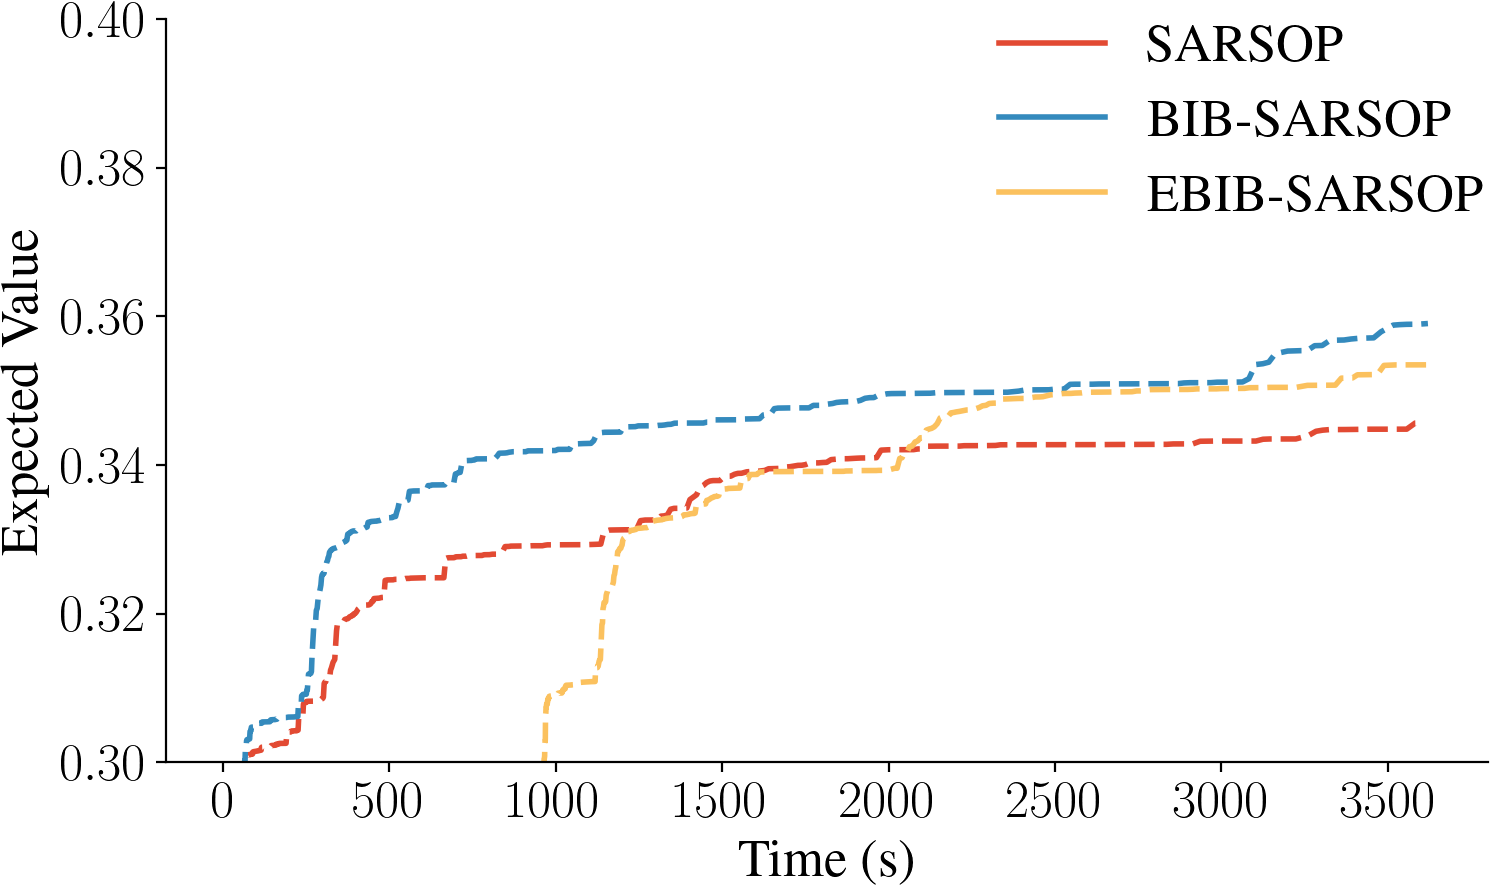

In [5]:
colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']
# colours = ["#7C16C6","#31E20C", "#FFA90D", "#F90D24",  "#FFF90D"]


ts, ubs, lbs, solvernames, envname = get_data_plot("SparseHallway2")

for (i,label) in enumerate(solvernames):
    plt.plot(ts[i][1:],ubs[i][1:], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i][1:],lbs[i][1:], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Expected Value")

plt.ylim(0.3, 0.4)
# plt.xlim(0,1000)
plt.legend()
plt.show()

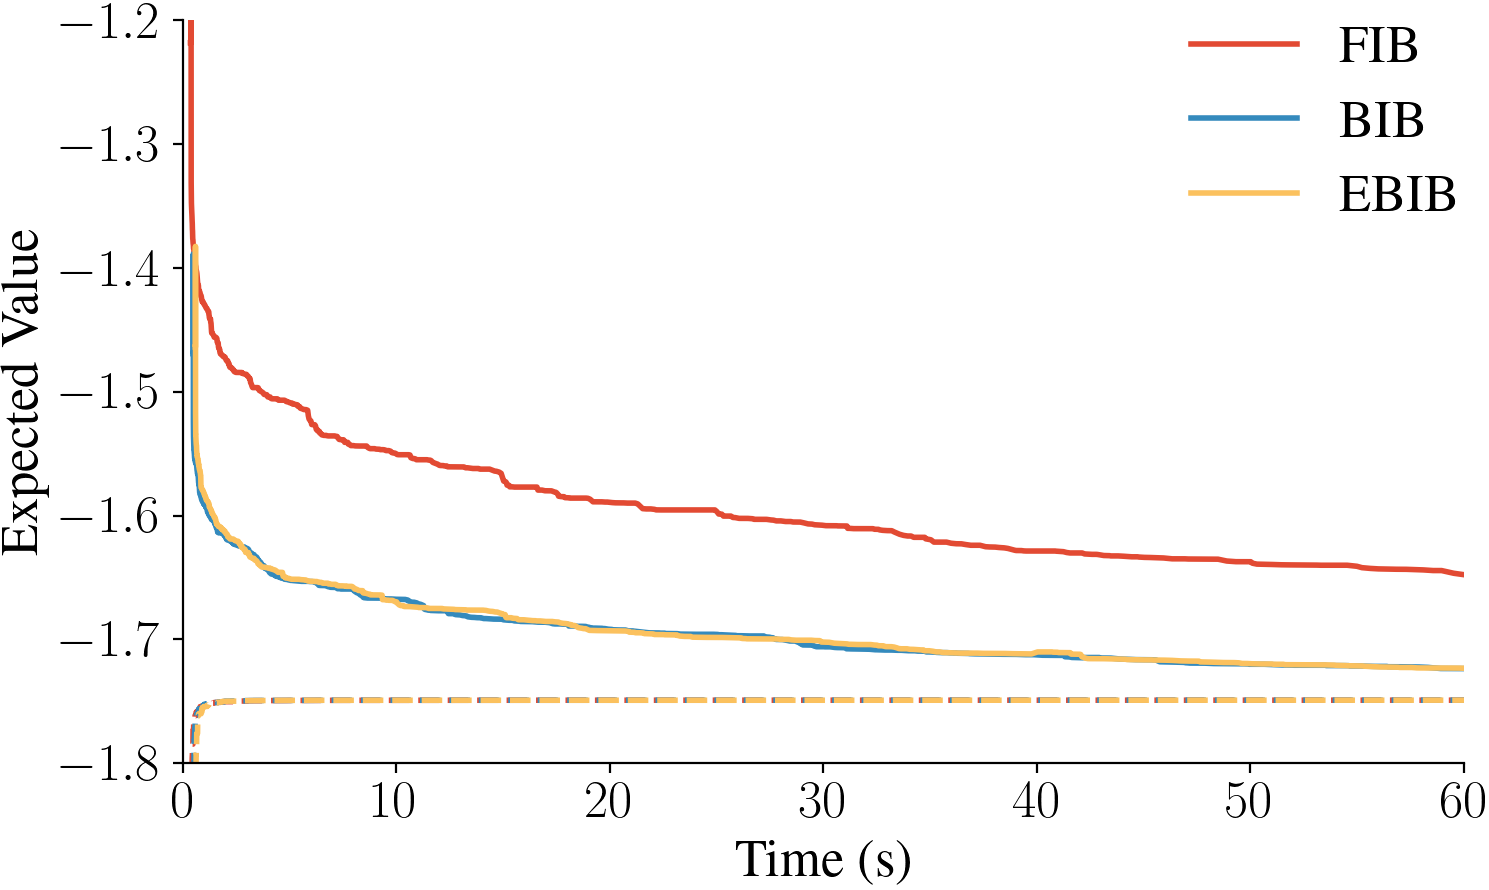

In [6]:
colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']
filename = "Data/Figures/SarsopTest_K-out-of-N2.pdf"


ts, ubs, lbs, solvernames, envname = get_data_plot("K-out-of-N2")

for (i,label) in enumerate(solvernames):
    label = solver_to_heuristic[label]
    plt.plot(ts[i],ubs[i], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i],lbs[i], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Expected Value")

plt.ylim(-1.8, -1.2)
plt.xlim(0,60)
plt.legend()
plt.savefig(filename, transparent=True)
plt.show()

In [7]:
### K-out-of-N2

# filename = "Data/Figures/SarsopTest_FrozenLake10.pdf"
# ts, ubs, lbs, solvernames, envname = get_data_plot("FrozenLake10")

# for (i,solver) in enumerate(solvernames):
#     label = solver_to_heuristic[solver]
#     # label = solver
#     plt.plot(ts[i],ubs[i], label=label, color=colours[i], linestyle="-")
#     plt.plot(ts[i],lbs[i], label=None, color=colours[i], linestyle="--")
#     # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
#     # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
#     # x,y  = ts[i][-1], lbs[i][-1]
#     # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

# plt.xlabel("Time (s)")
# plt.ylabel("Initial Value")

# plt.ylim(0.04, 0.165)
# plt.xlim(0, 60)
# plt.legend()
# plt.savefig(filename, transparent=True)
# plt.show()


In [8]:
# ### K-out-of-N2

# filename = "Data/Figures/SarsopTest_FrozenLake10.pdf"
# ts, ubs, lbs, solvernames, envname = get_data_plot("Tag")

# for (i,solver) in enumerate(solvernames):
#     label = solver_to_heuristic[solver]
#     # label = solver
#     plt.plot(ts[i],ubs[i], label=label, color=colours[i], linestyle="-")
#     plt.plot(ts[i],lbs[i], label=None, color=colours[i], linestyle="--")
#     # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
#     # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
#     # x,y  = ts[i][-1], lbs[i][-1]
#     # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

# plt.xlabel("Time (s)")
# plt.ylabel("Initial Value")

# plt.ylim(-12, -4)
# # plt.xlim(0, 60)
# plt.legend()
# plt.savefig(filename, transparent=True)
# plt.show()

# Discount Plotting

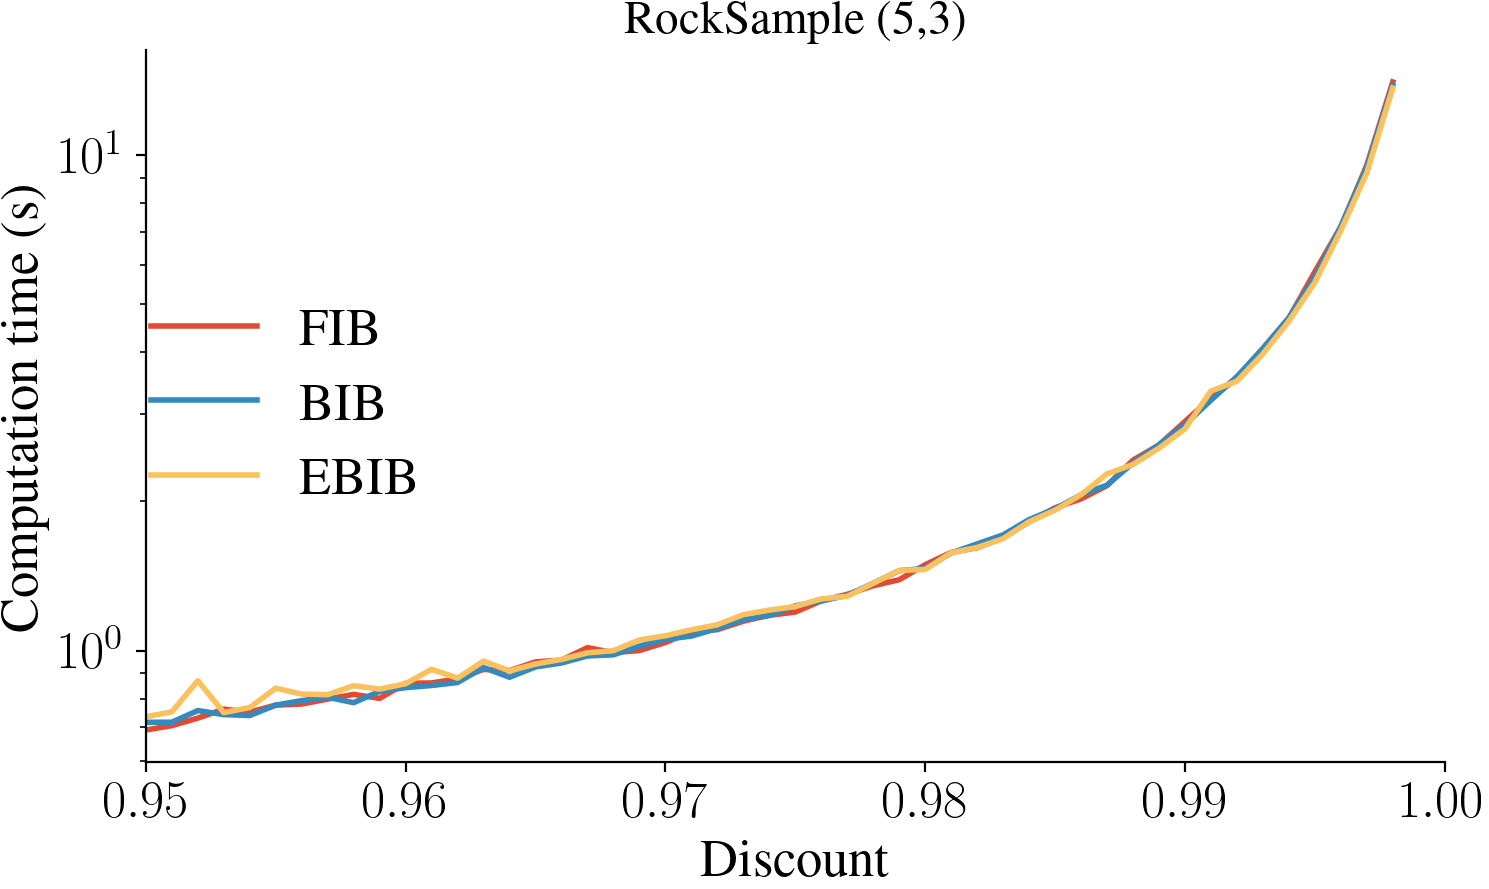

In [9]:
# FrozenLake5
filename = "Data/Figures/DiscountTest_RockSample5.pdf"
discounts = np.arange(0.95, 0.998, 0.001)
times, init_times, snames = get_data_discounts("RockSample5", discounts)

solvernames = ["FIB", "TIB", "ETIB"]

# plt.axhline(y=3600, label="TO", linestyle="--", color="0.5")

for (i,solver) in enumerate(solvernames):
    plt.plot(discounts,times[i], label=solver, color=colours[i], linestyle="-")

# Swithc TO to last on legend
handles, labels = plt.gca().get_legend_handles_labels()
# to_index = labels.index("TO")
# handles.append(handles.pop(to_index))
# labels.append(labels.pop(to_index))

plt.yscale("log")
plt.xlabel("Discount")
plt.ylabel("Computation time (s)")

plt.xlim(0.95, 1)
plt.legend(handles, labels, loc='center left')
plt.title("RockSample (5,3)")
plt.savefig(filename, transparent=True)
plt.show()

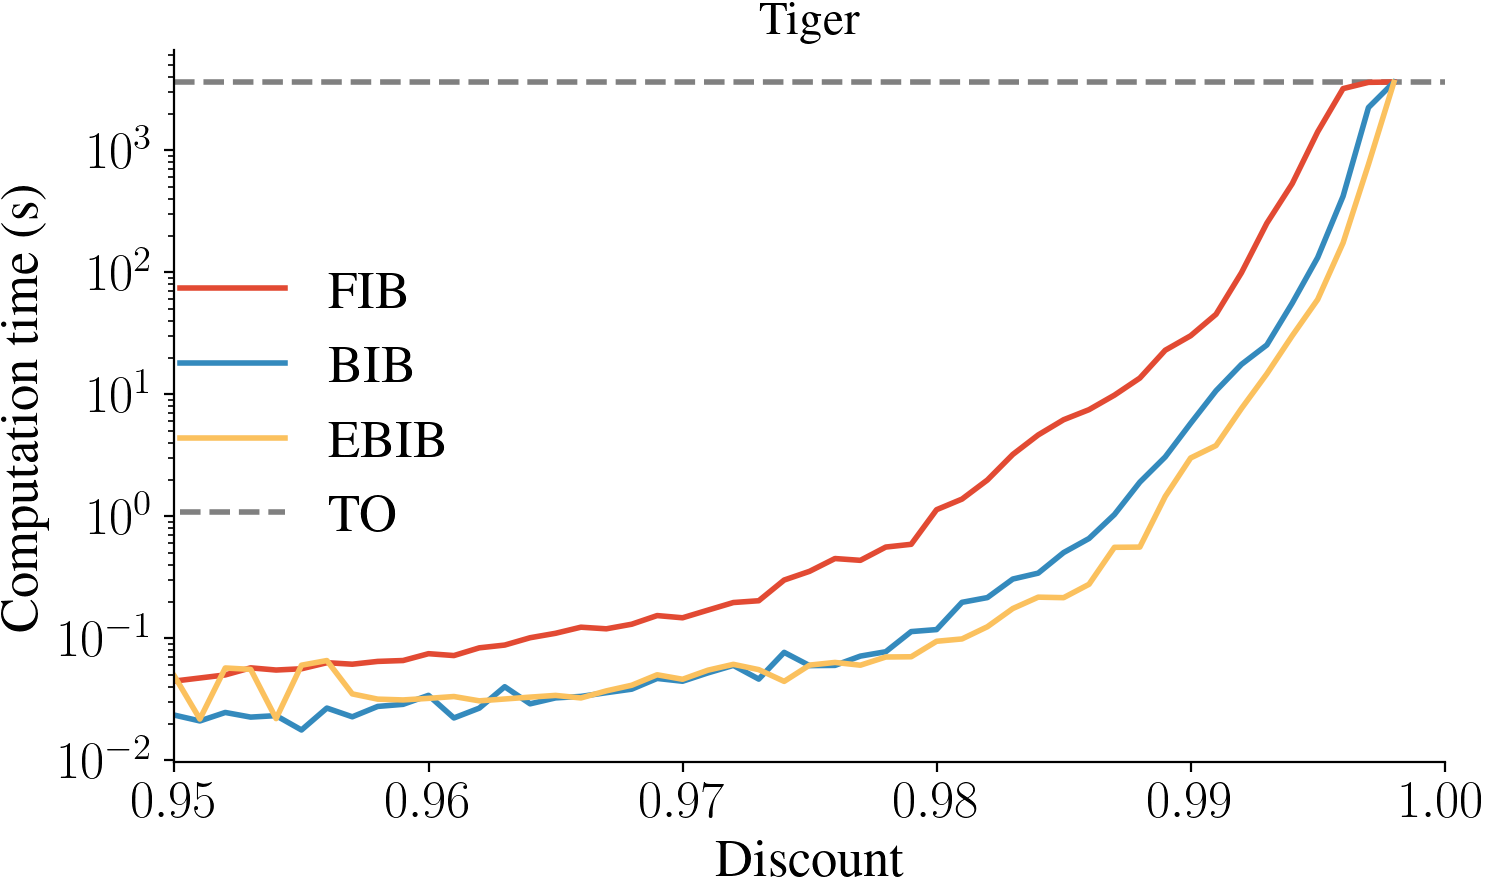

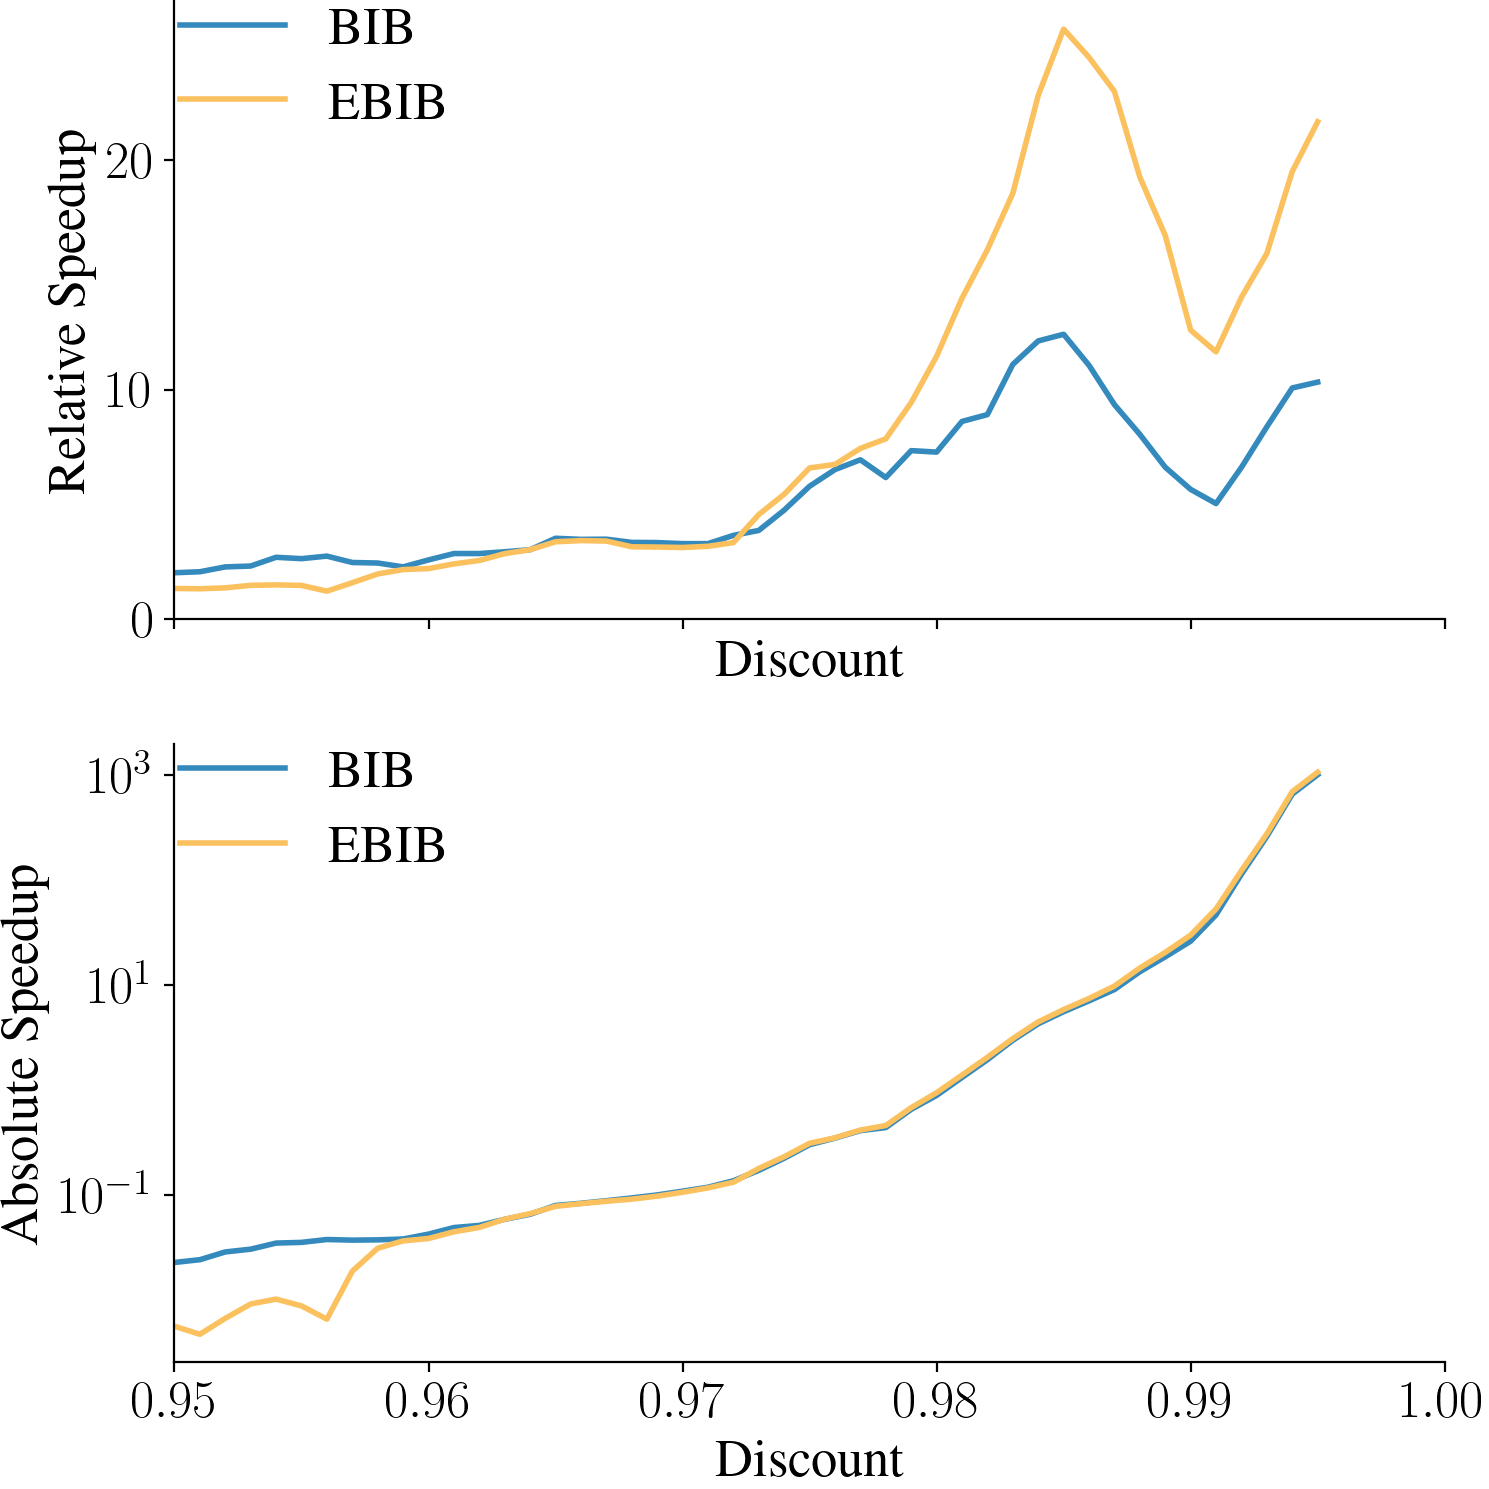

In [13]:
# Tiger
filename = "Data/Figures/DiscountTest_Tiger.pdf"
discounts = np.arange(0.95, 0.998, 0.001)
times, init_times, snames = get_data_discounts("Tiger", discounts)

solvernames = ["FIB", "TIB", "ETIB"]

plt.axhline(y=3600, label="TO", linestyle="--", color="0.5")

for (i,solver) in enumerate(solvernames):
    plt.plot(discounts,times[i], label=solver, color=colours[i], linestyle="-")

# Swithc TO to last on legend
handles, labels = plt.gca().get_legend_handles_labels()
to_index = labels.index("TO")
handles.append(handles.pop(to_index))
labels.append(labels.pop(to_index))

plt.yscale("log")
plt.xlabel("Discount")
plt.ylabel("Computation time (s)")

plt.xlim(0.95, 1)
plt.legend(handles, labels, loc='center left')
plt.title("Tiger")
plt.savefig(filename, transparent=True)
plt.show()

# cut out part where FIB times out:
for i in range(len(times)):
    times[i] = times[i][:-3]

discounts = discounts[:-3]


speedup_rel_TIB = savgol_filter(np.divide(times[0], times[1]), window_length=3, polyorder=0, mode="nearest")
speedup_rel_ETIB = savgol_filter(np.divide(times[0], times[2]), window_length=3, polyorder=0, mode="nearest")
speedup_abs_TIB = savgol_filter(np.subtract(times[0], times[1]), window_length=3, polyorder=0, mode="nearest")
speedup_abs_ETIB = savgol_filter(np.subtract(times[0], times[2]), window_length=3, polyorder=0, mode="nearest")
# plt.xlim(0.95, 1)
# # plt.ylim(0,25)
# plt.plot(discounts,speedup_rel_TIB, color=colours[1], linestyle="-", label="TIB")
# plt.plot(discounts,speedup_rel_ETIB, color=colours[2], linestyle="-", label="ETIB")
# plt.legend(loc="upper left")
# plt.xlabel("Discount")
# plt.ylabel("Relative Speedup")
# plt.savefig("Data/Figures/DiscountTest_Tiger_relspeedup.pdf")
# plt.show()
# plt.xlim(0.95, 1)
# # plt.ylim(0,1000)
# plt.plot(discounts,speedup_abs_TIB, color=colours[1], linestyle="-", label="TIB")
# plt.plot(discounts,speedup_abs_ETIB, color=colours[2], linestyle="-", label="ETIB")
# plt.legend(loc="upper left")
# plt.xlabel("Discount")
# plt.ylabel("Absolute Speedup")
# plt.yscale("log")
# plt.savefig("Data/Figures/DiscountTest_Tiger_absspeedup.pdf")
# plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# First subplot: Relative Speedup
ax1.set_xlim(0.95, 1)
ax1.plot(discounts, speedup_rel_TIB, color=colours[1], linestyle="-", label="TIB")
ax1.plot(discounts, speedup_rel_ETIB, color=colours[2], linestyle="-", label="ETIB")
ax1.legend(loc="upper left")
# ax1.set_yscale("log")
ax1.set_xlabel("Discount")
ax1.set_ylabel("Relative Speedup")
# ax1.set_title("Relative Speedup vs Discount")  # Optional title for clarity

# Second subplot: Absolute Speedup
ax2.set_xlim(0.95, 1)
ax2.plot(discounts, speedup_abs_TIB, color=colours[1], linestyle="-", label="TIB")
ax2.plot(discounts, speedup_abs_ETIB, color=colours[2], linestyle="-", label="ETIB")
ax2.legend(loc="upper left")
ax2.set_xlabel("Discount")
ax2.set_ylabel("Absolute Speedup")
ax2.set_yscale("log")
# ax2.set_title("Absolute Speedup vs Discount")  # Optional title for clarity

# Adjust the layout so the plots don't overlap
plt.tight_layout()

# Save the figure if needed
plt.savefig("Data/Figures/DiscountTest_Tiger_speedup_subplots.pdf")

# Display the plots
plt.show()



0.974
3508.9622650146484
404.3441159725189
474.68137407302856
0.97
1271.5575048923492
250.47479605674744
258.72852993011475
0.95
159.3457260131836
45.559507846832275
47.029032945632935


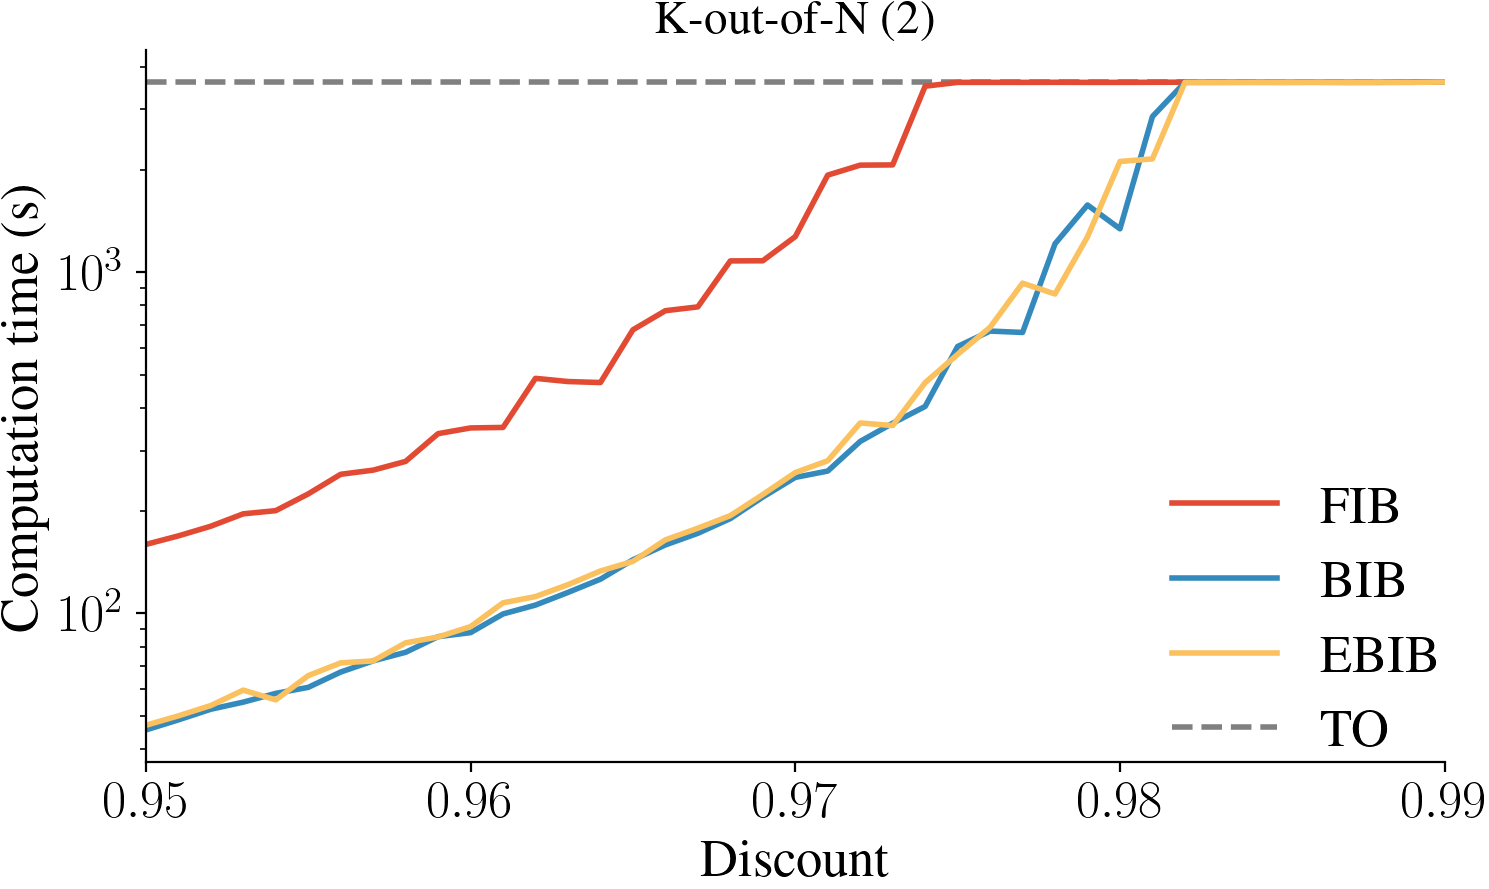

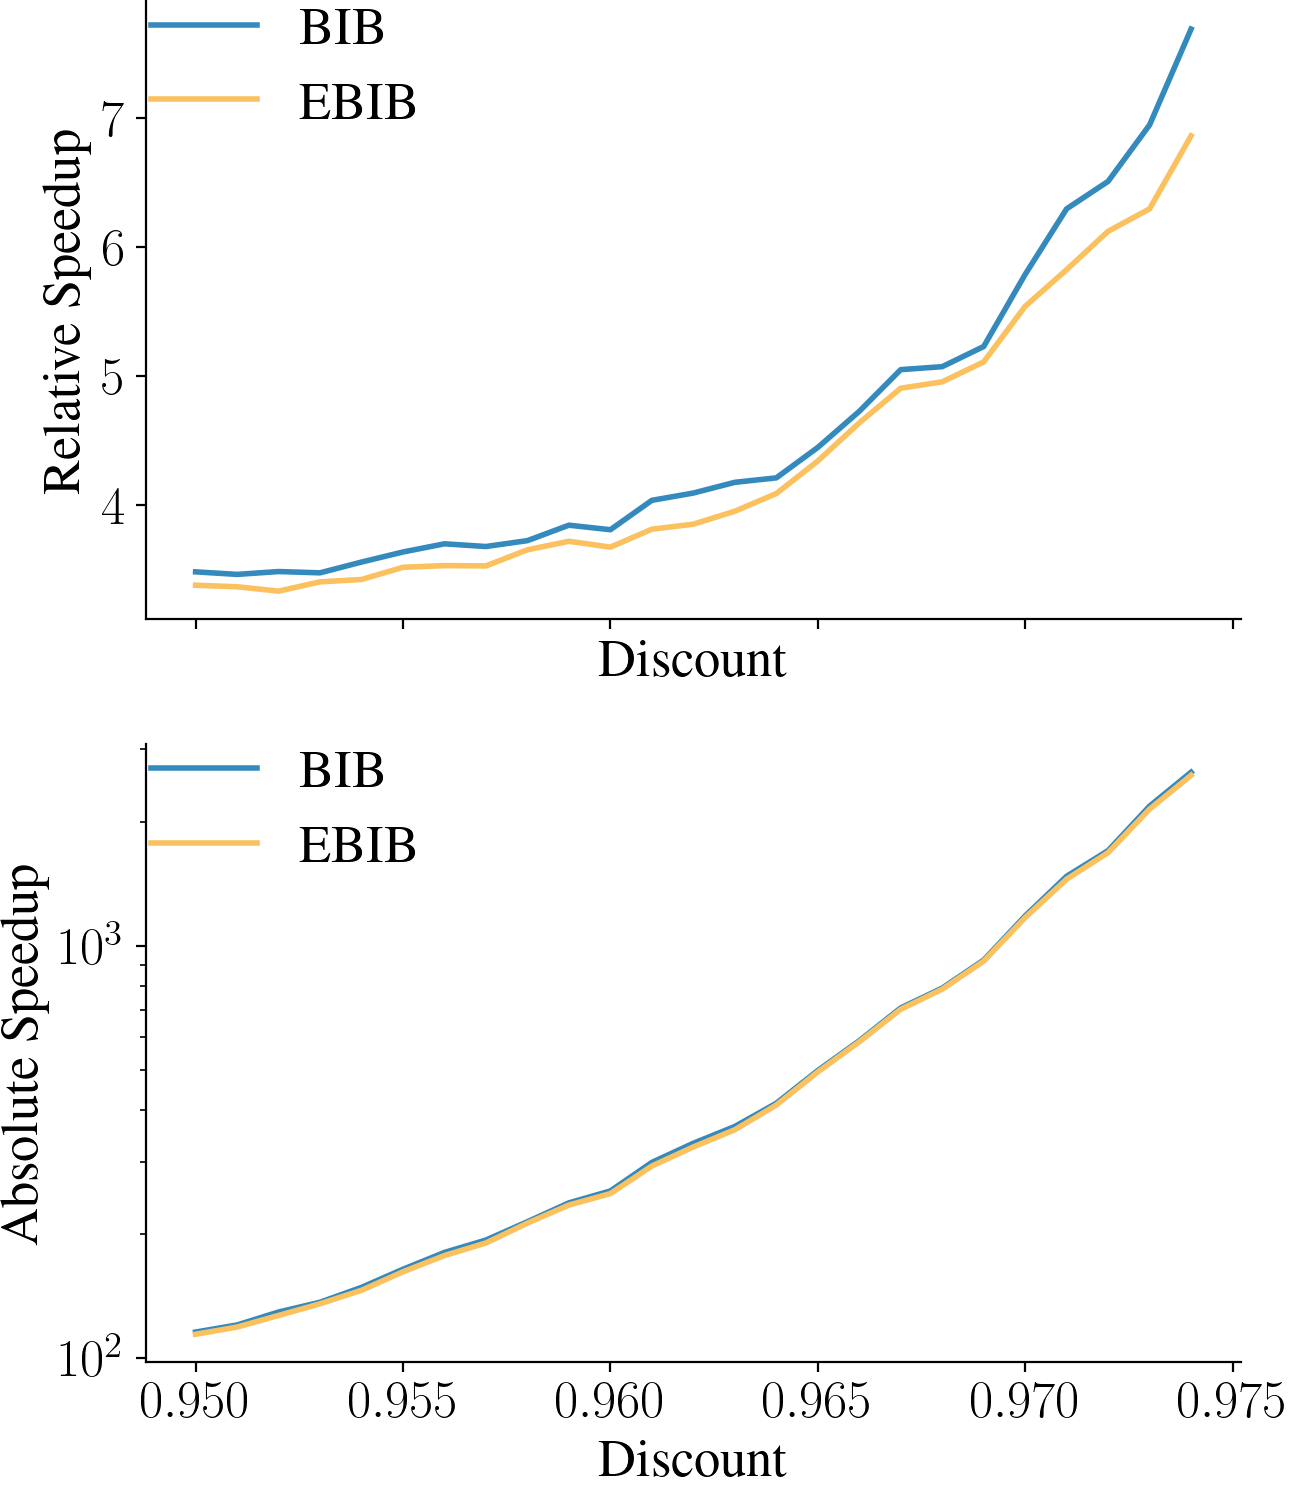

In [14]:
# K-out-of-N2
filename = "Data/Figures/DiscountTest_K-out-of-N2.pdf"
discounts = np.arange(0.95, 0.990, 0.001)
times, init_times, snames = get_data_discounts("K-out-of-N2", discounts)

solvernames = ["FIB", "TIB", "ETIB"]

plt.axhline(y=3600, label="TO", linestyle="--", color="0.5")

for (i,solver) in enumerate(solvernames):
    plt.plot(discounts,times[i], label=solver, color=colours[i], linestyle="-")

print(discounts[24])
print(times[0][24])
print(times[1][24])
print(times[2][24])

print(discounts[20])
print(times[0][20])
print(times[1][20])
print(times[2][20])

print(discounts[0])
print(times[0][0])
print(times[1][0])
print(times[2][0])

# Swithc TO to last on legend
handles, labels = plt.gca().get_legend_handles_labels()
to_index = labels.index("TO")
handles.append(handles.pop(to_index))
labels.append(labels.pop(to_index))

plt.yscale("log")
plt.xlabel("Discount")
plt.ylabel("Computation time (s)")

plt.xlim(0.95, 0.99)
plt.legend(handles, labels, loc='best')
plt.title("K-out-of-N (2)")
plt.savefig(filename, transparent=True)
plt.show()

# cutoff = 16
cutoff = 16
for i in range(len(times)):
    times[i] = times[i][:-cutoff]

discounts = discounts[:-cutoff]


speedup_rel_TIB = savgol_filter(np.divide(times[0], times[1]), window_length=3, polyorder=0, mode="nearest")
speedup_rel_ETIB = savgol_filter(np.divide(times[0], times[2]), window_length=3, polyorder=0, mode="nearest")
speedup_abs_TIB = savgol_filter(np.subtract(times[0], times[1]), window_length=3, polyorder=0, mode="nearest")
speedup_abs_ETIB = savgol_filter(np.subtract(times[0], times[2]), window_length=3, polyorder=0, mode="nearest")
# speedup_rel_TIB = np.divide(times[0], times[1])
# speedup_rel_ETIB = np.divide(times[0], times[2])
# speedup_abs_TIB = np.subtract(times[0],times[1])
# speedup_abs_ETIB = np.subtract(times[0],times[2])
# plt.xlim(0.95, 0.974)
# plt.ylim(0,25)
# plt.plot(discounts,speedup_rel_TIB)#, color=colours[i], linestyle="-")
# plt.plot(discounts,speedup_rel_ETIB)#, color=colours[i], linestyle="-")
# plt.show()
# # plt.xlim(0.95, 0.974)
# # plt.ylim(0,1000)
# plt.plot(discounts,speedup_abs_TIB)#, color=colours[i], linestyle="-")
# plt.plot(discounts,speedup_abs_ETIB)#, color=colours[i], linestyle="-")
# # plt.yscale("log")
# plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# First subplot: Relative Speedup
# ax1.set_xlim(0.95, 1)
ax1.plot(discounts, speedup_rel_TIB, color=colours[1], linestyle="-", label="TIB")
ax1.plot(discounts, speedup_rel_ETIB, color=colours[2], linestyle="-", label="ETIB")
ax1.legend(loc="upper left")
# ax1.set_yscale("log")
ax1.set_xlabel("Discount")
ax1.set_ylabel("Relative Speedup")
# ax1.set_title("Relative Speedup vs Discount")  # Optional title for clarity

# Second subplot: Absolute Speedup
# ax2.set_xlim(0.95, 1)
ax2.plot(discounts, speedup_abs_TIB, color=colours[1], linestyle="-", label="TIB")
ax2.plot(discounts, speedup_abs_ETIB, color=colours[2], linestyle="-", label="ETIB")
ax2.legend(loc="upper left")
ax2.set_xlabel("Discount")
ax2.set_ylabel("Absolute Speedup")
ax2.set_yscale("log")
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position("right")
# ax2.spines['right'].set_position(('outward', 0))  # Move the right spine outwards to become the primary y-axis
# ax2.spines['left'].set_visible(False)  # Hide the left y-axis spine
# ax2.spines['right'].set_visible(True)
ax2.set_ylabel("Absolute Speedup")
# ax2.set_title("Absolute Speedup vs Discount")  # Optional title for clarity

# Adjust the layout so the plots don't overlap
plt.tight_layout()

# Save the figure if needed
plt.savefig("Data/Figures/DiscountTest_K-out-of-N2_speedup_subplots.pdf")

# Display the plots
plt.show()



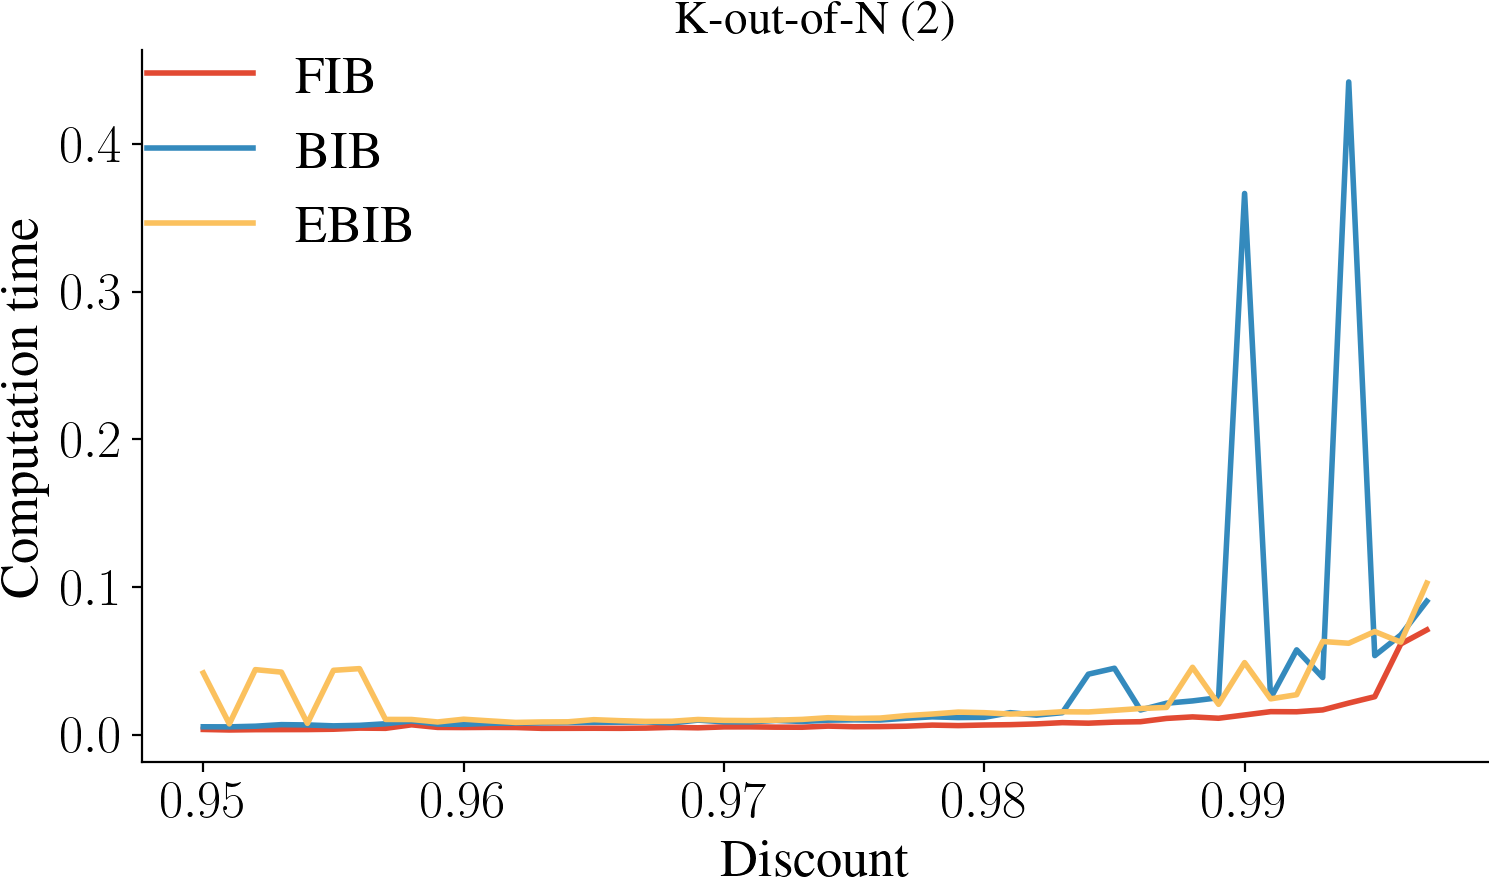

In [12]:
# K-out-of-N2
filename = "Data/Figures/DiscountTest_K-out-of-N2_heuristic.pdf"
discounts = np.arange(0.95, 0.998, 0.001)
times, init_times, snames = get_data_discounts("Tiger", discounts)

solvernames = ["FIB", "TIB", "ETIB"]

# plt.axhline(y=3600, label="TO", linestyle="--", color="0.5")

for (i,solver) in enumerate(solvernames):
    plt.plot(discounts[:-1],init_times[i][:-1], label=solver, color=colours[i], linestyle="-")

# Swithc TO to last on legend
handles, labels = plt.gca().get_legend_handles_labels()
# to_index = labels.index("TO")
# handles.append(handles.pop(to_index))
# labels.append(labels.pop(to_index))

# plt.yscale("log")
plt.xlabel("Discount")
plt.ylabel("Computation time")

# plt.xlim(0.95, 0.99)
plt.legend(handles, labels, loc='best')
plt.title("K-out-of-N (2)")
plt.savefig(filename, transparent=True)
plt.show()